# Linear Models in Machine Learning on Python - Robust Regression and Outliers

Welcome to the 10th notebook. In this notebook we will talk about outliers, and by extension of this, we will talk about some regression models grouped as Robust Regression which are robust to outliers. This notebook will be actually an introduction for outlier detection because I will only show statistical methods to detect outliers, however, there are some other techniques "so-called" automated outlier detection algorithms. We will learn these algorithms in the following notebooks.

In [186]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)
from scipy.special import inv_boxcox
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
import plotly as py
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', module='sklearn')
sns.set()

## Outliers

#### What is an outlier?

An outlier is basically an 	unexpected instance in your dataset. More formally, outliers are the instances that has values extremely above or below than most of the instances in your dataset. You can find more about outliers or what cases them on [Wikipedia](https://en.wikipedia.org/wiki/Outlier). 


I will load the covid dataset that we used in the previous notebooks and use three statistical methods to detect outliers.

1. Standard Deviation
2. Interquartile Range
3. Z-Score

Let's get started.

In [2]:
data=pd.read_csv("covidtenmost.csv")

In [3]:
data.head(5)

,Country,Date,Sum_Confirmed,sum_Recovered,sum_Deaths,sum_Active,Median_CaseFatalityRatio,Median_IncidenceRate,Lat,Lon
0,United Kingdom,2020-03-23 00:00:00,6726,140,336,6250,NaN,NaN,56.4907,-4.2026
1,United Kingdom,2020-03-24 00:00:00,8164,140,423,7601,NaN,NaN,56.4907,-4.2026
2,United Kingdom,2020-03-25 00:00:00,9640,140,466,9034,NaN,NaN,56.4907,-4.2026
3,United Kingdom,2020-03-26 00:00:00,11812,150,580,11082,NaN,NaN,56.4907,-4.2026
4,United Kingdom,2020-03-27 00:00:00,14745,151,761,13833,NaN,NaN,56.4907,-4.2026


### Standard Deviation for Outlier Detection

In GLM notebook, I talked about standard deviation but it is good to define it one more time. Standard deviation is a parameter that shows variance in our data. We can use this parameter for detecting outliers. 


Since we find the outliers in our response feature, let's fistly extract it.

In [187]:
target=data["sum_Deaths"]

I will use `histplot()` to show the distribution of target features.

<AxesSubplot:xlabel='sum_Deaths', ylabel='Count'>

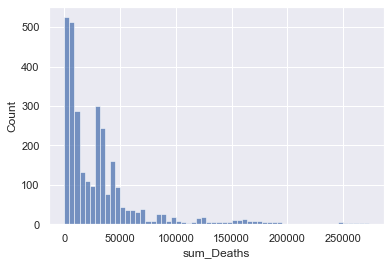

In [188]:
sns.histplot(target)

It's especially good to use standard deviation in outlier detection when we our target is normally distributed. Unfortunately, our target doesn't seem to be normally distributed. We can also show that by using `normaltest()` function that we have utilized in the linear regression notebooks.

In [189]:
normaltest(target)

NormaltestResult(statistic=1717.7943140505013, pvalue=0.0)

Even though it is not normally distributed we can convert it by using boxcox. Let's apply `boxcox()` transformation to get our data as close as normally distributed.

In [190]:
boxcox_transform = boxcox(target)
boxcox_target = boxcox_transform[0]
lam = boxcox_transform[1]

In [191]:
normaltest(boxcox_target)

NormaltestResult(statistic=4.22067112499016, pvalue=0.12119729034393358)

<AxesSubplot:ylabel='Count'>

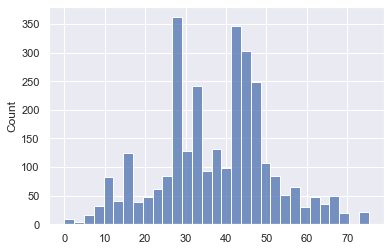

In [192]:
sns.histplot(boxcox_target)

It seems better now (we can actually use standard deviation for outlier detection without transforming the target but it is generally suggested, that's why, I wanted to mention it.) 


**Now the question is how are we supposed to use standard deviation to detect outliers ?** 


Well the idea is pretty simple, we will calculate the mean and standard deviation. Afterwards, we will define a range by using mean and standard deviation. For instance, let's say that the mean is 87 and standard deviation is 9. By using two times standard deviation we can define lower and upper limits (79-96) and exclude all the values out of this range. You can tune the multiplier of standard deviation according to your data and change the range.

In [10]:
mean=np.mean(boxcox_target)
std=np.std(boxcox_target)
cutoff = std * 2 
lower_limit, upper_limit = mean - cutoff, mean + cutoff

Let's detect outliers by using this range.

In [11]:
outliers = [x for x in boxcox_target if x < lower_limit or x > upper_limit]

In [ ]:
outliers

The values above are detected outliers. Let's get rid of them using the code below.

In [13]:
outliers_removed = [x for x in boxcox_target if x > lower_limit and x < upper_limit]

In [ ]:
outliers_removed

How many instances did we lose when we deleted the outliers ? 

This is a very important question because we don't want to lose much of our data. You can tune the range according to the percentage of data you lose. 

Let's see the data we lost in percantage.

In [15]:
prtc=(len(outliers)/(len(outliers_removed)+len(outliers)))*100
print('Percantage of outliers removed from data: %f',prtc )

Percantage of outliers removed from data: %f 5.214214546662239


We deleted %5 of our data. I don't think it is much for the dataset we have, however, this is relative decision. You may not to lose %5 of your data in your project. Moreover, you may sometimes need to train some modes on both outlier-deleted and outlier-free datasets to see how it affects the training. My aim here not to give you much tips about real life examples but to provide you the algorithms and techniques. I will share some additional sources for tips for using these techniques in real life examples.

Let's also delete the outliers from the dataframe.

In [16]:
outliers_removed = data[((boxcox(data["sum_Deaths"])[0] > lower_limit) & (boxcox(data["sum_Deaths"])[0] < upper_limit))]

In [17]:
outliers_removed

,Country,Date,Sum_Confirmed,sum_Recovered,sum_Deaths,sum_Active,Median_CaseFatalityRatio,Median_IncidenceRate,Lat,Lon
0,United Kingdom,2020-03-23 00:00:00,6726,140,336,6250,NaN,NaN,56.490700,-4.202600
1,United Kingdom,2020-03-24 00:00:00,8164,140,423,7601,NaN,NaN,56.490700,-4.202600
2,United Kingdom,2020-03-25 00:00:00,9640,140,466,9034,NaN,NaN,56.490700,-4.202600
3,United Kingdom,2020-03-26 00:00:00,11812,150,580,11082,NaN,NaN,56.490700,-4.202600
4,United Kingdom,2020-03-27 00:00:00,14745,151,761,13833,NaN,NaN,56.490700,-4.202600
...,...,...,...,...,...,...,...,...,...,...
3005,Russia,2021-03-08 00:00:00,4274263,3867901,87614,318748,1.590251,2701.669090,52.968543,36.069248
3006,Russia,2021-03-09 00:00:00,4284408,3878189,87985,318234,1.594498,2711.950481,52.968543,36.069248
3007,Russia,2021-03-10 00:00:00,4293750,3888071,88315,317364,1.598784,2722.076093,52.968543,36.069248
3008,Russia,2021-03-11 00:00:00,4302726,3901134,88773,312819,1.603109,2732.123816,52.968543,36.069248


### Z-Score for Outlier Detection

Another statistical method that we can use is Z-score. This method is actually quite similar to using standard deviation. Here the aim is to have a measure of how far a point from mean is and use that measure for detecting outliers. <br><br>$$z=\frac{X-\mu }{\sigma }$$

By using the equation above we will calculate Z-scores and then we will exclude all the instance that is above a threshold that we choose. You can read more about Z-score in these articles [link1](https://www.statisticshowto.com/probability-and-statistics/z-score/) [link2](https://www.investopedia.com/terms/z/zscore.asp#:~:text=A%20Z%2Dscore%20is%20a,identical%20to%20the%20mean%20score.) [link3](https://www.spss-tutorials.com/z-scores-what-and-why/#:~:text=Z%2Dscores%20are%20also%20known,are%20not%20necessarily%20normally%20distributed.)


In [18]:
from scipy import stats

I will calculate Z-Score and then delete some parts of datasets that is above a threshold. It is sometimes recommended to convert or to use Z-Score with normally distributed data as standard deviation. However, I will not do that this time. I will go with an trial-error perspective for finding the threshold.

In [193]:
z = np.abs(stats.zscore(data["sum_Deaths"]))
print(z)

[0.77113773 0.76900447 0.7679501  ... 1.39735986 1.4084185  0.77589466]


In [194]:
outliers=data[(z > 2)]
len(outliers) # number of instances that will be deleted.

177

As we did above let's delete the outliers from the dataframe.

In [195]:
outliers_removed = data[(z < 2)]
outliers_removed

,Country,Date,Sum_Confirmed,sum_Recovered,sum_Deaths,sum_Active,Median_CaseFatalityRatio,Median_IncidenceRate,Lat,Lon
0,United Kingdom,2020-03-23 00:00:00,6726,140,336,6250,NaN,NaN,56.490700,-4.202600
1,United Kingdom,2020-03-24 00:00:00,8164,140,423,7601,NaN,NaN,56.490700,-4.202600
2,United Kingdom,2020-03-25 00:00:00,9640,140,466,9034,NaN,NaN,56.490700,-4.202600
3,United Kingdom,2020-03-26 00:00:00,11812,150,580,11082,NaN,NaN,56.490700,-4.202600
4,United Kingdom,2020-03-27 00:00:00,14745,151,761,13833,NaN,NaN,56.490700,-4.202600
...,...,...,...,...,...,...,...,...,...,...
3006,Russia,2021-03-09 00:00:00,4284408,3878189,87985,318234,1.594498,2711.950481,52.968543,36.069248
3007,Russia,2021-03-10 00:00:00,4293750,3888071,88315,317364,1.598784,2722.076093,52.968543,36.069248
3008,Russia,2021-03-11 00:00:00,4302726,3901134,88773,312819,1.603109,2732.123816,52.968543,36.069248
3009,Russia,2021-03-12 00:00:00,4311893,3914866,89224,307803,1.607376,2741.937871,52.968543,36.069248


Let's see what percentage of our data we lost.

In [196]:
prtc=(len(outliers)/(len(outliers_removed)+len(outliers)))*100

In [25]:
print('Non-outlier observations: %f',prtc )

Non-outlier observations: %f 5.878445699103288


It's similar to the percantage that we lost using standard deviation.

### Interquartile Range for Outlier Detection

The last statistical method that we will use for outliers detection is interquartile range. We previously talked about interquartile range to some extent while using boxplot and describe function. Let's define it formally this time:

#####  *Interquartile range is defined as the spread difference between the 75th and 25th percentiles of the data* 

In other words, Interquartile range is the difference between third and first quartile (IQR = Q3 − Q1). You can find more about IQR on [Wikipedia](https://en.wikipedia.org/wiki/Interquartile_range#:~:text=In%20descriptive%20statistics%2C%20the%20interquartile,25th%20percentiles%20of%20the%20data.). I also took the picture below from Wikipedia to visualize the situation. We will use $Q1-1.5IQR$ and $Q3+1.5IQR$ range to select the instances and exclude all the other instances out of this range. Furthermore, one of the good part of using interquartile range we don't need to convert the feature into normally distributed form because it is not related to mean.

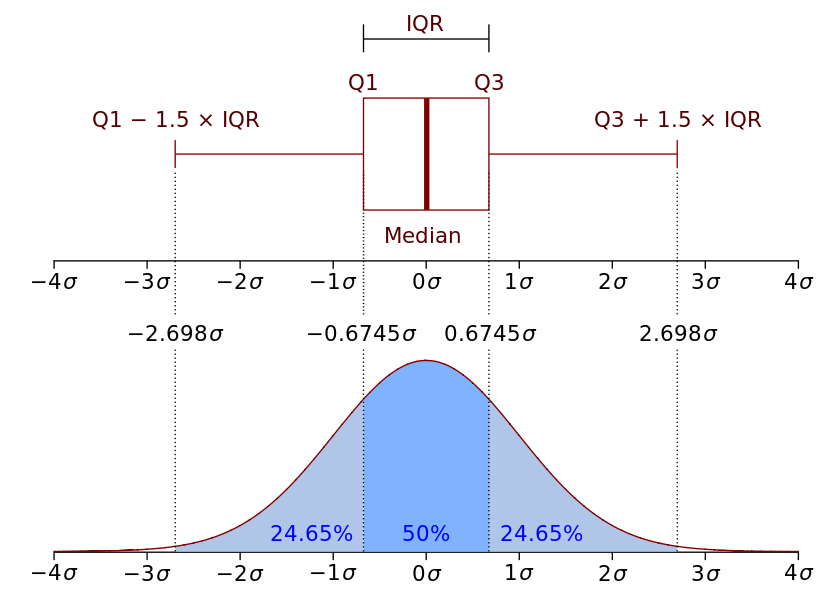

We will use percentile function to find first and third quartile.

In [26]:
from numpy import percentile
q1, q3 = percentile(target, 25), percentile(target, 75)
IQR = q1 - q3

Now let's define upper and lower bouns

In [27]:
lower, upper = q1 - (IQR * 1.5), q3 + (IQR * 1.5)

Finally we can find the outliers and get rid of them.

In [28]:
outliers = [x for x in target if x > lower or x < upper]
len(outliers)

418

418 instances will be deleted from the dataset. Let's also delete them from the dataframe.

In [29]:
outliers_removed = data[~((data["sum_Deaths"] > lower) | (data["sum_Deaths"]< upper))]
outliers_removed

,Country,Date,Sum_Confirmed,sum_Recovered,sum_Deaths,sum_Active,Median_CaseFatalityRatio,Median_IncidenceRate,Lat,Lon
0,United Kingdom,2020-03-23 00:00:00,6726,140,336,6250,NaN,NaN,56.490700,-4.202600
1,United Kingdom,2020-03-24 00:00:00,8164,140,423,7601,NaN,NaN,56.490700,-4.202600
2,United Kingdom,2020-03-25 00:00:00,9640,140,466,9034,NaN,NaN,56.490700,-4.202600
3,United Kingdom,2020-03-26 00:00:00,11812,150,580,11082,NaN,NaN,56.490700,-4.202600
4,United Kingdom,2020-03-27 00:00:00,14745,151,761,13833,NaN,NaN,56.490700,-4.202600
...,...,...,...,...,...,...,...,...,...,...
2982,Russia,2020-12-27 00:00:00,2992123,2402122,53539,536462,1.337610,1768.134087,52.968543,36.069248
2983,Russia,2020-12-28 00:00:00,3019972,2426094,54080,539798,1.334368,1780.261207,52.968543,36.069248
2984,Russia,2020-12-29 00:00:00,3047335,2446412,54559,546364,1.323586,1792.272830,52.968543,36.069248
2985,Russia,2020-12-30 00:00:00,3073923,2470783,55107,548033,1.336388,1804.168957,52.968543,36.069248


What percantage of the data did we lose ? Let's find it again.

In [30]:
prtc=(len(outliers)/(len(outliers_removed)+len(outliers)))*100

In [31]:
print('Non-outlier observations: %f',prtc )

Non-outlier observations: %f 13.882431086017935


We lost more data than we lost when we used standard deviation and z-score. It's actually a big problem to lose the %13 percent of data, and normally It would be better to tune the range so that we can lose less data, however, this is just an introduction. Therefore, I will not tune it but I recommend trying that. We will see which method is better in our case when we use some regression models on the data. 


Before moving on, let's use box plot on both the actual response feature and outliers-free response feature.

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sum_Deaths'>

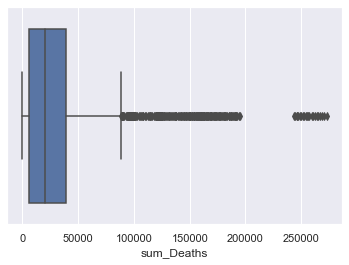

In [32]:
sns.boxplot(target)

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sum_Deaths'>

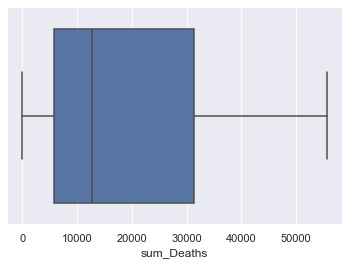

In [33]:
sns.boxplot(outliers_removed["sum_Deaths"])

For the methods above I recommend reading these articles 

1. [Detect and Remove the Outliers using Python on GeeksforGeeks](https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/) 

2. [Ways to Detect and Remove the Outliers](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)

3. [Three ways to detect outliers](http://colingorrie.github.io/outlier-detection.html)

Finally, let's define a function that we can use for using all of the methods above.

In [37]:
def outlier_remover(data,method):
    target=data["sum_Deaths"];
    if(method=="IQR"):
        q1, q3 = percentile(target, 25), percentile(target, 75)
        IQR = q1 - q3  
        lower, upper = q1 - (IQR * 1.5), q3 + (IQR * 1.5)
        outliers_removed = data[~((data["sum_Deaths"] > lower) | (data["sum_Deaths"]< upper))]
        return outliers_removed
    
    elif(method=="zscore"):
        z = np.abs(stats.zscore(target))
        outliers_removed = data[(z < 2)]
        return outliers_removed
    
    elif(method=="std"):
        target=data["sum_Deaths"]
        boxcox_transform = boxcox(target)
        boxcox_target = boxcox_transform[0]
        mean_score = boxcox_target.mean()
        std_score=np.std(boxcox_target)
        cutoff = std_score * 2 
        lower_limit, upper_limit = mean_score - cutoff, mean_score + cutoff
        outliers_removed = data[((boxcox(data["sum_Deaths"])[0] > lower_limit) & (boxcox(data["sum_Deaths"])[0] < upper_limit))]
        return outliers_removed

We are done with outlier detection for now. There are more techniques that you can use for example, we can use One Class Classification or functions like `LocalOutlierFactor()` to detect outliers. However, I'm thinking of introducing these techniques after I introduce dimensionality reduction and clustering. Anyway, I will provide some Machine Learning Mastery articles that you can read in advance to learn more about these techniques. 

1. [How to Identify Outliers in your Data](https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/)

2. [How to Remove Outliers for Machine Learning](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)

3. [4 Automatic Outlier Detection Algorithms in Python](https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/)

Additionally, there is an important concept to discuss briefly. Even though I deleted the outliers above it is not always good to do that. What do i mean ? 
In some situations it is better to keep outliers because they may keep very useful information for us. I will not go into details about this but will share some discussions in which you can read more about.



4. [Should we exclude outliers form testing set?](https://www.quora.com/Should-we-exclude-outliers-form-testing-set#:~:text=You%20don't%20remove%20outliers,large%20bank%20accounts%20or%20fraud.)

5. [Why would you not remove outliers from a data set?](https://www.quora.com/Why-would-you-not-remove-outliers-from-a-data-set)

6. [Should we remove/replace outliers when we deal with a working production dataset? We had some outlier handling during training/testing.](https://www.quora.com/Should-we-remove-replace-outliers-when-we-deal-with-a-working-production-dataset-We-had-some-outlier-handling-during-training-testing)

7. [Outliers: To Drop or Not to Drop](https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/)

8. [Outliers handling](https://datascience.stackexchange.com/questions/44764/outliers-handling)

I also recommend watching ritvikmath's video about outliers [link](https://www.youtube.com/watch?v=7KeITQajazo)

## Robust Regression

The mean aim of this notebook is providing some ways to deal with outliers. One approach that we can use for dealing with outliers while performing regression tasks is robust regression. The idea behind robust regression is simple, instead of using our classical linear regression (Ordinary Least Squares) we will use some different types of linear regression that are more robust to outliers. The question is then what makes them more prone to outliers ? Robust Regression models use cost functions that are different than the one we had for OLS or they just use different sampling strategies. Let's explore these models more deeply and understand what makes them prone.

### Huber Regression

I will firstly introduce a Robust Regression algorithm called Huber Regression. The main difference of this regression type (compared to OLS) is that we are using a cost function called Huber Loss. Before defining Huber Loss let's recall  the one we used in OLS.<br><br>
$$ OLS \: Cost\  Function: J\left(\theta\right)=\frac{1}{2m}\sum _{i=1}^m\left(h_\theta \left(x^{\left(i\right)}\right)-y^{\left(i\right)}\right)^2$$

Instead of this cost function above, we will use the one below. 

$$L_{\delta \:}\left(y,f\left(x\right)\right)=\begin{cases}\frac{1}{2}\left(y-f\left(x\right)\right)^2&,\:for\:\left|y-f\left(x\right)\right|\le \delta \:\:\:\\ \delta \left(\left|y-f\left(x\right)\right|-\frac{1}{2}\delta \:\right)&,\:otherwise\end{cases}$$

This is the general form of Huber Loss. We are using sort of different version in sklearn library and I will write it down as well but first let's understand this one. Huber lose, to some extent, combines both Mean Squared Error and Mean Absolute Error. MSE error is good for learning outliers, this may affect performance of our model when we have many outliers in our data. On the other hand, MAE is good for ignoring outliers but this time our model may not be able to generalize well for extraordinary points. With this cost function we are trying to combine powerful sides of both MSE and MAE, and to do that, we are using a quadratic loss function for values below delta(this is actually a threshold) and using a linear loss for large values. That gives us the advantage of weighting outliers less to strike a balance.

Sklearn uses a bit different version of Huber Loss

$$min_{w,\:\sigma }\sum _{i=1}^m\left(\sigma +H_{\epsilon \:}\left(\frac{X_i\cdot \:w-y_i}{\sigma \:}\right)\sigma \:+\alpha \cdot w^2_2\:\right)\:$$

where

$$H_{\epsilon }\left(z\right)=\begin{cases}z^2&if\:\left|z\right|<\epsilon \:\\ \:2\epsilon \left|z\right|-\epsilon \:^2&,\:otherwise\end{cases}$$

* The Huber Regressor optimizes the squared loss for the samples where |(y - X'w) / sigma| < epsilon and the absolute loss for the samples where |(y - X'w) / sigma| > epsilon, where w and sigma are parameters to be optimized. The parameter sigma makes sure that if y is scaled up or down by a certain factor, one does not need to rescale epsilon to achieve the same robustness.

Additionally, we have ridge regression term in the sklearn version of cost function. Hence, the function works as I explained but we have some other terms to make it more suitable for regression.

I recommend reading these articles on Loss Functions and Huber Regression.
1. [Understanding the 3 most common loss functions for Machine Learning Regression](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3)
2. [Huber regression: different formulations](http://yetanothermathprogrammingconsultant.blogspot.com/2021/09/huber-regression-different-formulations.html)
3. [Huber Loss: Why Is It, Like How It Is?](https://www.cantorsparadise.com/huber-loss-why-is-it-like-how-it-is-dcbe47936473)



### Theil Sen Regression

Theil Sen Regression is another Robust Regression algorithm that we can use on Sklearn. The part of the algorithm that makes it to be prone to outliers doesn't come with loss function but the way it computes weight(slope) and intercept. We saw that in Generalized Linear Models we used mean and link function to link linear predictor and mean. In this regression algorithm, median is calculated to find best weight and intercept. The reason for using median is that median does not get affected much by outliers. The algorithm firstly computes slopes between instances and find median of these slopes. The median of slopes will be the slope of our regression line. Using this slope, the algorithm fits a line through every predictor,target values to calculate N number of intercepts. And lastly, choose the median of the intercepts to use for the main regression line. In the end we fit different regression lines to obtain median of slope and median of intecepts for generating our model.

I recommend checking out these articles for Theil Sen Regression.
1. [The Theil-Sen robust estimator for simple linear regression](https://blogs.sas.com/content/iml/2019/05/28/theil-sen-robust-regression.html)
2. [Some Regression Techniques with Outliers](https://blog.jovian.ai/some-regression-techniques-with-outliers-d69361c74726)
3. [A correlation measure based on Theil-Sen regression](https://towardsdatascience.com/a-correlation-measure-based-on-theil-sen-regression-31b8b9ed64f1)


### RANSAC Regression

Random Sample Consensus Regression a.k.a RANSAC Regression is not actually a regression model but it is an very efficient way of performing regression which is also robust to outliers. The main idea is that by randomly sampling our data RANSAC tries to exclude outliers and fit the model on inliers only. Let's go through the algorithm step by step.

1. The algorithm firstly samples a subset of the data we have and then fit a linear regression model on this subset.
2. Then by using the model that is fitted on subset of data, the model is tested on remaining instances. 
3. In the next step algorithm calculates residuals on test data, idetify outliers based on large residuals, and then exclude the outliers, finally refit the model on inliers.
4. We repeat that procedure on different subsets and test the model on the remaining data again. In the end the algorithm chooses the best model fitted and returns it.



How do we choose the number of samples ? We use the equation below to find number of samples <br><br> $$N=\frac{log\left(1-p\right)}{log\left(1-\left(1-e\right)^s\right)}$$

In the equation
1. N: number of samples
2. e: probability that a point is an outlier
3. S: number of instances in a sample
4. p: probability that at least one sample contains only inliers.

This equation derived from the one below. <br><br>
$$1-\left(1-\left(1-e\right)^s\right)^N=p$$<br>
I explained this equation part by part in the picture below and if we leave N alone, we can find the number of samples that we are interested. Generally, we set p=0.99 so that we make sure at least one sample contains only inliers. This is also the default in sklearn. However, this is also a hyperparameter and we will tune it by using GridSearchCV to see whether or not this default number works best for our model.

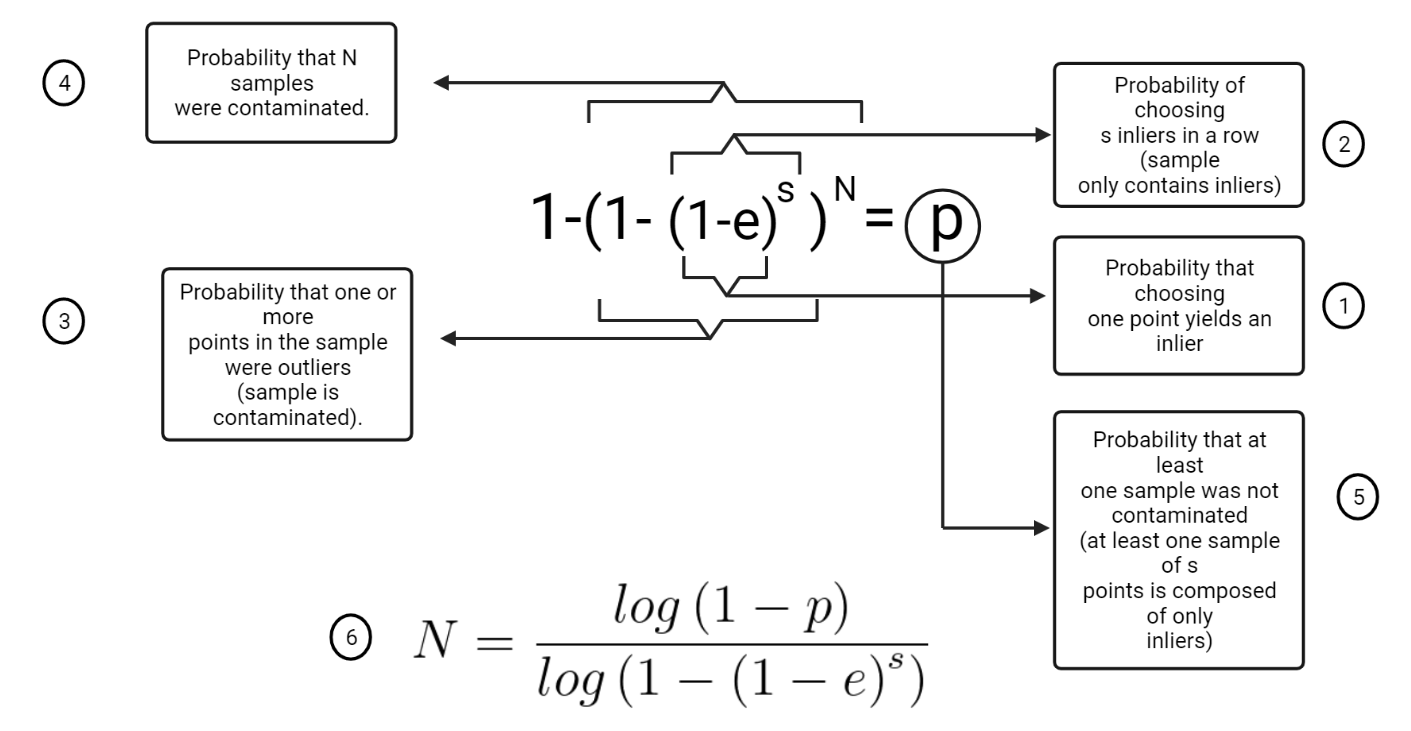

I recommend reading these article about RANSAC Regession to learn more about this algorithm

1. [Does RANSAC is a robust approach for outliers detection?](https://medium.datadriveninvestor.com/does-ransac-is-a-robust-approach-for-outliers-detection-5ddd3720345)

2. [Introduction to RANSAC](https://sanyamkapoor.com/kb/introduction-to-ransac)

It is especially important to understand how we choose number of samples. Pen State University provides good lecture notes [link](https://www.youtube.com/watch?v=UKhh_MmGIjM) in which you can find a good explanation of RANSAC Algorithm as well as how the algorithm chooses the number of samples. I actually took some of the part above from this lecture notes and additionally, I also recommend watching this [video](https://www.youtube.com/watch?v=UKhh_MmGIjM) as a suplementary material for the lecture note.

### Some Notes on Robust Regression Models

I took below part from Sklearn documentation ([link](https://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors)). I think these are some important notes about these algorithms, therefore, I wanted them to write down here.

**Trade-offs: which estimator?**

1. HuberRegressor should be faster than RANSAC and Theil Sen unless the number of samples are very large, i.e n_samples >> n_features. This is because RANSAC and Theil Sen fit on smaller subsets of the data. However, both Theil Sen and RANSAC are unlikely to be as robust as HuberRegressor for the default parameters.

2. HuberRegressor differs from TheilSenRegressor and RANSACRegressor because it does not ignore the effect of the outliers but gives a lesser weight to them.

3. RANSAC is faster than Theil Sen and scales much better with the number of samples.

4. RANSAC will deal better with large outliers in the y direction (most common situation).

5. Theil Sen will cope better with medium-size outliers in the X direction, but this property will disappear in high-dimensional settings.

6. When in doubt, use RANSAC.

Also we can also use `SGDRegressor()` with Huber loss but there are some differences.

The HuberRegressor differs from using SGDRegressor with loss set to huber in the following ways.

1. HuberRegressor is scaling invariant. Once epsilon is set, scaling X and y down or up by different values would produce the same robustness to outliers as before. as compared to SGDRegressor where epsilon has to be set again when X and y are scaled.

2. HuberRegressor should be more efficient to use on data with small number of samples while SGDRegressor needs a number of passes on the training data to produce the same robustness.

<br><br>


Now it's time to use these models. Firstly, I will import the version of the dataset we used above combined with attiributes that we generated in the 4th notebook. Then I will use `outlier_remover()` function that we created to process this data using different outlier detection approaches. I will use Ridge, Huber, Theil-Sen, and RANSAC Regression on all of the datafames we generated by using outlier_remover(). Moreover, I will use Ridge Regression as baseline model because it was the one we got the best scores in the 4th notebook.

In [34]:
data_rendered=pd.read_csv("covidrendered.csv")
data_rendered.drop('Unnamed: 0', inplace=True, axis=1) # unnessary column

In [35]:
data_rendered

,Country,sum_Confirmed,sum_Recovered,sum_Deaths,sum_Active,Median_IncidenceRate,Population,Number of Hospitals,Hospital_Capacity,Infected_Population,Death_intensity,Death2recovered
0,United Kingdom,6726,140.0,336,6250,NaN,66727461,1257,0.096871,5142.375231,92.685714,2.400000
1,United Kingdom,8164,140.0,423,7601,NaN,66727461,1257,0.079734,4232.633111,112.607143,3.021429
2,United Kingdom,9640,140.0,466,9034,NaN,66727461,1257,0.067313,3573.281622,133.385714,3.328571
3,United Kingdom,11812,150.0,580,11082,NaN,66727461,1257,0.054905,2914.626583,152.626667,3.866667
4,United Kingdom,14745,151.0,761,13833,NaN,66727461,1257,0.043985,2334.924102,189.258278,5.039735
...,...,...,...,...,...,...,...,...,...,...,...,...
3006,Russia,4284408,3878189.0,87985,318234,2711.950481,145530082,5300,0.001152,31.618814,1.186802,0.022687
3007,Russia,4293750,3888071.0,88315,317364,2722.076093,145530082,5300,0.001149,31.560721,1.185964,0.022714
3008,Russia,4302726,3901134.0,88773,312819,2732.123816,145530082,5300,0.001148,31.530422,1.183129,0.022756
3009,Russia,4311893,3914866.0,89224,307803,2741.937871,145530082,5300,0.001147,31.502091,1.180039,0.022791


Deleting outliers by using standard deviation.

In [ ]:
data_std=outlier_remover(data_rendered,"std")

Deleting outliers by using IQR.

In [ ]:
data_iqr=outlier_remover(data_rendered,"IQR")

Deleting outliers by using Z-Score.

In [ ]:
data_zscore=outlier_remover(data_rendered,"zscore")

As you remember we also did some preprocessing steps in the 4th notebook. I will define a function that does all of the steps in 4th notebook.

In [70]:
def process(data):
    data_cp=data.copy()
    target=data_cp["sum_Deaths"]
    data_all=data_cp.loc[:,['Country','sum_Confirmed','sum_Recovered','Death_intensity','Hospital_Capacity',
                   'sum_Active','Median_IncidenceRate','Population','Number of Hospitals','Infected_Population','Death2recovered']] # some part of our that
    num_data=data_cp.loc[:,['sum_Confirmed','sum_Recovered','sum_Active','Hospital_Capacity',
                      'Median_IncidenceRate','Population','Number of Hospitals','Infected_Population','Death2recovered','Death_intensity']] #numerical columns
    cat_data=data_cp['Country']# categorical columns
    data_cp.drop(["sum_Deaths"],inplace=True,axis=1)
    
    
    num_attribs = list(num_data)
    cat_attribs = ['Country']
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ('polynomial_features',PolynomialFeatures(degree=2)),
        
    ])
    
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
    covid_prepared = full_pipeline.fit_transform(data_all)
    return covid_prepared,target

Let's apply the function above to dataframes we have.

In [44]:
data_zscore_pcs,target_zscore=process(data_zscore)
len(data_zscore_pcs)

2834

In [45]:
data_iqr_pcs,target_iqr=process(data_iqr)
len(data_iqr_pcs)

2593

In [46]:
data_std_pcs,target_std=process(data_std)
len(data_std_pcs)

2854

In [71]:
data_processed,target=process(data_rendered)
len(data_processed)

3011

We are ready to use Regression algorithms on our data. I will use  `Ridge()`,`HuberRegressor()`,`TheilSenRegressor()` and `RANSACRegressor()` functions on the dataframes one by one. Also I will use `GridSearchCV()` for hyperparameter tuning. 

## Ridge Regression

For ridge regression, I will use almost the same code as the one I used in the 4th notebook. However, since I will train different models on all of the dataframes, I don't want to rewrite the same code again and again. Therefore, I will combine the codes in a function and use this function each time. 

In [50]:
def GridSearchRidge(regressors,response):
    X_train,X_test,y_train,y_test = train_test_split(regressors,response, test_size=0.3, random_state=42,shuffle=True)
    kf = KFold(shuffle=True, random_state=42, n_splits=10)
    ridge=Ridge(max_iter=300)
    params = {
    'alpha': np.geomspace(1e-9, 1e1, num=10),
    'solver': ('svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'),
    'fit_intercept': (True, False),
     }
    grdcv=GridSearchCV(ridge, params, scoring='neg_mean_squared_error',verbose=2,return_train_score=True, cv=kf).fit(X_train, y_train)
    results = {'MSE':mean_squared_error(y_test,grdcv.predict(X_test)),
           'Best_Model':grdcv.best_estimator_,
           'CV_results':pd.DataFrame(grdcv.cv_results_),
           'RSquared':r2_score(y_test,grdcv.predict(X_test))}
    return results

Let's firstly apply the function to the main dataset that we didn't process for any outliers.

In [ ]:
results_ridge = GridSearchRidge(data_processed,target)

Now I will apply the function to other dataframes.

In [ ]:
results_ridge_std = GridSearchRidge(data_std_pcs,target_std)

In [ ]:
results_ridge_iqr = GridSearchRidge(data_iqr_pcs,target_iqr)

In [ ]:
results_ridge_zscore = GridSearchRidge(data_zscore_pcs,target_zscore)

## Huber Regression

I will follow the same approach that I followed above. The difference is going to be that we will use different parameters for tuning since we are using a different regressor. For Huber Regression we have only one different hyperparameter that I will optimize which is epsilon. Epsilon is the same parameter as delta in the cost function of Huber Regression. We will use squared loss if |(y - X'w) / sigma| below epsilon and absolute loss otherwise. You can find more about parameters of that function in its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html)

In [61]:
from sklearn.linear_model import HuberRegressor

In [73]:
def GridSearchHuber(regressors,response):
    X_train,X_test,y_train,y_test = train_test_split(regressors,response, test_size=0.3, random_state=42,shuffle=True)
    kf = KFold(shuffle=True, random_state=42, n_splits=10)
    hbr_reg = HuberRegressor(max_iter=300)
    params = {
    'alpha': np.geomspace(1e-9, 1e1, num=10),
    'fit_intercept': (True, False),
    'warm_start':(True,False),
    'epsilon': [1,1.35,1.90,2.50,3.50,5,6,8,11,17]
     }
    grdcv=GridSearchCV(hbr_reg, params, scoring='neg_mean_squared_error',verbose=2,return_train_score=True, cv=kf).fit(X_train, y_train)
    results = {'MSE':mean_squared_error(y_test,grdcv.predict(X_test)),
           'Best_Model':grdcv.best_estimator_,
           'CV_results':pd.DataFrame(grdcv.cv_results_),
           'RSquared':r2_score(y_test,grdcv.predict(X_test))}
    return results

In [ ]:
results_huber = GridSearchHuber(data_processed,target)

In [ ]:
results_huber_std = GridSearchHuber(data_std_pcs,target_std)

In [ ]:
results_huber_iqr = GridSearchHuber(data_iqr_pcs,target_iqr)

In [ ]:
results_huber_zscore = GridSearchHuber(data_zscore_pcs,target_zscore)

### Theil-Sen Regression

For Theil-Sen Regression we have more hyperparameters to tune such as max_subpopulation or n_subsamples. I will only optimize n_subsamples here because it takes a lot of time for the process to terminate otherwise. As we discussed the algorithm samples the data into subgroups and calculates median for getting optimal slope and bias term. **n_subsamples** defines the number of samples to calculate the parameters. You can find more about in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TheilSenRegressor.html)

In [85]:
from sklearn.linear_model import TheilSenRegressor

In [153]:
TheilSenRegressor().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'max_iter', 'max_subpopulation', 'n_jobs', 'n_subsamples', 'random_state', 'tol', 'verbose'])

In [102]:
def GridSearchTheilSen(regressors,response):
    X_train,X_test,y_train,y_test = train_test_split(regressors,response, test_size=0.3, random_state=42,shuffle=True)
    kf = KFold(shuffle=True, random_state=42, n_splits=10)
    theilsen_reg = TheilSenRegressor(max_iter=300)
    params = {
    'fit_intercept': (True, False),
    'n_subsamples': [None,100,300,500,750,1000]
     }
    grdcv=GridSearchCV(theilsen_reg, params, scoring='neg_mean_squared_error',verbose=2,return_train_score=True, cv=kf).fit(X_train, y_train)
    results = {'MSE':mean_squared_error(y_test,grdcv.predict(X_test)),
           'Best_Model':grdcv.best_estimator_,
           'CV_results':pd.DataFrame(grdcv.cv_results_),
           'RSquared':r2_score(y_test,grdcv.predict(X_test))}
    return results

In [103]:
np.geomspace(1e1, 1e10, num=10)

array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10])

In [ ]:
results_theilsen = GridSearchTheilSen(data_processed,target)

In [ ]:
results_theilsen_std = GridSearchTheilSen(data_std_pcs,target_std)

In [ ]:
results_theilsen_iqr = GridSearchTheilSen(data_iqr_pcs,target_iqr)

In [ ]:
results_theilsen_zscore = GridSearchTheilSen(data_zscore_pcs,target_zscore)

### RANSAC Regression

RANSAC Regression has its own parameters as well. I will use GridSearch for optimizing max_trials, stop_probability, loss and residual_threshold. Let's explore these hyperparameters.

1. **max_trials:** Maximum number of iterations for random sample selection.
2. **stop_probability:** Defines the probability value that I showed you in the equation above. 
3. **loss:** we can use two different loss MAE and MSE, I will use both of them and we will see which one is the best for this example.
4. **residual_threshold:** Maximum residual for a data sample to be classified as an inlier. By default the threshold is chosen as the MAD (median absolute deviation) of the target values y. Here I will pass other threshold by using statistical functions like standard deviation(std), median, mean, interquartile range(iqr) geometric mean(gmean)

For more about parameters check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html)

In [114]:
from sklearn.linear_model import RANSACRegressor

In [116]:
RANSACRegressor().get_params().keys()

dict_keys(['base_estimator', 'is_data_valid', 'is_model_valid', 'loss', 'max_skips', 'max_trials', 'min_samples', 'random_state', 'residual_threshold', 'stop_n_inliers', 'stop_probability', 'stop_score'])

In [ ]:
ransac_reg=RANSACRegressor()

In [142]:
def GridSearchRANSACReg(regressors,response):
    X_train,X_test,y_train,y_test = train_test_split(regressors,response, test_size=0.3, random_state=42,shuffle=True)
    kf = KFold(shuffle=True, random_state=42, n_splits=10)
    ransac_reg=RANSACRegressor()
    params = {
    'max_trials': [100,200,300],
    'stop_probability': [0.50,0.75,0.99],
    'loss': ["absolute_loss","squared_loss"],
    "residual_threshold":[None,np.std(response),np.median(response),np.mean(response),stats.iqr(response),stats.gmean(response)]
     }
    grdcv=GridSearchCV(ransac_reg, params, scoring='neg_mean_squared_error',verbose=2,return_train_score=True, cv=kf).fit(X_train, y_train)
    results = {'MSE':mean_squared_error(y_test,grdcv.predict(X_test)),
           'Best_Model':grdcv.best_params_,
           'CV_results':pd.DataFrame(grdcv.cv_results_),
           'RSquared':r2_score(y_test,grdcv.predict(X_test))}
    return results

In [ ]:
results_ransac = GridSearchRANSACReg(data_processed,target)

In [ ]:
results_ransac_std = GridSearchRANSACReg(data_std_pcs,target_std)  

In [ ]:
results_ransac_iqr = GridSearchRANSACReg(data_iqr_pcs,target_iqr) 

In [ ]:
results_ransac_zscore = GridSearchRANSACReg(data_zscore_pcs,target_zscore)

Let's combine all of the results into one dataframe.

In [185]:
mse_vals = [results_ridge["MSE"],results_huber["MSE"],format(results_theilsen["MSE"],'.20f'),format(results_ransac["MSE"],'.20f')]
mse_vals_std = [format(results_ridge_std["MSE"],'f'),format(results_huber_std["MSE"],'f'),format(results_theilsen_std["MSE"],'.20f'),format(results_ransac_std["MSE"],'.20f')]
mse_vals_iqr = [results_ridge_iqr["MSE"],results_huber_iqr["MSE"],format(results_theilsen_iqr["MSE"],'.20f'),format(results_ransac_iqr["MSE"],'.20f')]
mse_vals_zscore = [results_ridge_zscore["MSE"],results_huber_zscore["MSE"],format(results_theilsen_zscore["MSE"],'.20f'),format(results_ransac_zscore["MSE"],'.20f')]
                   
rsquared_vals = [results_ridge["RSquared"],results_huber["RSquared"],results_theilsen["RSquared"],results_ransac["RSquared"]]
rsquared_vals_std = [results_ridge_std["RSquared"],results_huber_std["RSquared"],results_theilsen_std["RSquared"],results_ransac_std["RSquared"]]
rsquared_vals_iqr = [results_ridge_iqr["RSquared"],results_huber_iqr["RSquared"],results_theilsen_iqr["RSquared"],results_ransac_iqr["RSquared"]]
rsquared_vals_zscore = [results_ridge_zscore["RSquared"],results_huber_zscore["RSquared"],results_theilsen_zscore["RSquared"],results_ransac_zscore["RSquared"]]




labels = {0:'Ridge Regression',1:'Huber Regression', 2:'Theil-Sen Regression',3:'RANSAC Regression'}
columns={0:'MSE',1:'MSE_STD',2:'MSE_IQR',3:'MSE_ZScore',4:'RSquared',5:'RSquared_STD',6:'RSquared_IQR',7:'RSquared_ZScore'}

df =pd.DataFrame([mse_vals, mse_vals_std,mse_vals_iqr,mse_vals_zscore,rsquared_vals,rsquared_vals_std,rsquared_vals_iqr,rsquared_vals_zscore])
df.rename(columns=labels, index=columns, inplace=True)
df

,Ridge Regression,Huber Regression,Theil-Sen Regression,RANSAC Regression
MSE,0.196578,19585296.381193,0.00000000000000111941,0.00000000000003856169
MSE_STD,0.036545,9861551.677262,0.00000000000000053549,0.00000000000000118153
MSE_IQR,0.000209,8800808.57689,0.00000000000000005323,0.00000000000000019985
MSE_ZScore,0.009175,27313499.035608,0.00000000000000005318,0.00000000000000058599
RSquared,1.0,0.987736,1.0,1.0
RSquared_STD,1.0,0.988934,1.0,1.0
RSquared_IQR,1.0,0.963208,1.0,1.0
RSquared_ZScore,1.0,0.944007,1.0,1.0


Okay it seems like Ridge, Theil-Sen and RANSAC models performs very well, whereas, Huber Regression isn't good for our data.

There are some things that I want to recommend at this point. I actually planned to plat change of metrics during hyperparameter tuning as I did in 4th notebook but I'm always being suggested by people not to make this notebooks very long, therefore, I leave doing this to you. Equally important, as we discussed before outliers can convey a lot of useful information. It's not always good to delete the outliers or perhaps sometimes you can only delete them from training set and keep the ones in test set. In the end, it depends on what you want, sometimes deleting them can be good but sometimes you want your model to be able to capture anomalies as well. I will talk more about this when I introduce other methods to capture outliers. Additionally, It can be a good example to do on this dataset deleting outliers from training set but not from test set and see how the performance changes.

Lastly I found some good notes about detecting outliers provided by LMU Munchen [link](https://archive.siam.org/meetings/sdm10/tutorial3.pdf)